<a href="https://colab.research.google.com/github/Romira915/jds_compe/blob/main/compe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install mecab-python3 transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/My Drive/Documents/compe/train.csv"
test_path = "/content/drive/My Drive/Documents/compe/test.csv"
compe_path = "/content/drive/My Drive/Documents/compe/compe.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import time

import MeCab
import numpy as np
import pandas as pd
import torch
import transformers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import Tensor, cuda, optim
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoModel, AutoTokenizer, BertJapaneseTokenizer,
                          BertModel)

In [17]:
torch.cuda.empty_cache()

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
compe_df = pd.read_csv(compe_path)

train_df, valid_df = train_test_split(
    train_df, test_size=0.2, shuffle=True)

train_text = train_df["text"].values.astype('U')
valid_text = valid_df["text"].values.astype('U')
test_text = test_df["text"].values.astype('U')
y = train_df["label"].values.astype("int8")
valid_y = valid_df["label"].values.astype("int8")
test_y = test_df["label"].values.astype("int8")
compe_text = compe_df["text"].values.astype('U')

# model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [18]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        y_tensor = torch.Tensor(
            [1, 0]) if self.y[index] == 1 else torch.Tensor([0, 1])

        return {
            'ids': torch.LongTensor(ids),
            'mask': torch.LongTensor(mask),
            'labels': y_tensor
        }

In [19]:
# 最大系列長の指定
MAX_LEN = 128

# tokenizerの取得
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

# Datasetの作成
dataset_train = CreateDataset(
    train_text, y, tokenizer, MAX_LEN)
dataset_valid = CreateDataset(
    valid_text, valid_y, tokenizer, MAX_LEN)
dataset_test = CreateDataset(
    test_text, test_y, tokenizer, MAX_LEN)

for var in dataset_train[0]:
    print(f'{var}: {dataset_train[0][var]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([    2,  2098, 28444, 28591,     6,  4717, 29968,    14,     1, 22314,
         3215,   241, 28587,    14,    31,     5,     7,  4492,    20,    80,
         3215,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, pretrained, drop_rate, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained)
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, output_size)  # BERTの出力に合わせて768次元を指定

    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask, return_dict=False)
        print(out)
        out = self.fc(self.drop(out))
        return out

In [21]:
def calculate_loss_and_accuracy(model, loader, device, criterion=None):
    """ 損失・正解率を計算"""
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 順伝播
            outputs = model(ids, mask)

            # 損失計算
            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            # バッチサイズの長さの予測ラベル配列
            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            # バッチサイズの長さの正解ラベル配列
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(labels)
            correct += (pred == labels).sum().item()

    return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in dataloader_train:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(
            model, dataloader_train, device, criterion=criterion)
        loss_valid, acc_valid = calculate_loss_and_accuracy(
            model, dataloader_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    return {'train': log_train, 'valid': log_valid}

In [22]:
# パラメータの設定
DROP_RATE = 0.7
OUTPUT_SIZE = 2
BATCH_SIZE = 8
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(model_name, DROP_RATE, OUTPUT_SIZE)
8
# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE,
                  model, criterion, optimizer, NUM_EPOCHS, device=device)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` a

ストリーミング出力は最後の 5000 行に切り捨てられました。
       device='cuda:0')
tensor([[-0.6615, -0.5503,  0.4969,  ..., -0.6139, -0.1821,  0.1173],
        [ 0.2685, -0.4009,  0.5292,  ..., -0.8970, -0.2385,  0.4745],
        [ 0.6899, -0.4898,  0.4342,  ..., -0.7891, -0.1758,  0.6384],
        ...,
        [-0.8816,  0.3524, -0.8129,  ...,  0.9071,  0.8389, -0.8005],
        [ 0.5786,  0.0245,  0.7913,  ..., -0.9060, -0.5051,  0.6694],
        [ 0.7616, -0.4092,  0.6443,  ..., -0.9226, -0.6624,  0.5375]],
       device='cuda:0')
tensor([[ 0.9644, -0.1245,  0.6891,  ..., -0.8887, -0.4730,  0.4950],
        [-0.4668,  0.3758, -0.6749,  ...,  0.9104,  0.7807, -0.4551],
        [-0.9499,  0.2707, -0.8430,  ...,  0.9618,  0.9006, -0.7867],
        ...,
        [-0.8345,  0.3947, -0.7601,  ...,  0.9362,  0.8388, -0.7416],
        [-0.7818,  0.4698, -0.7249,  ...,  0.9307,  0.8224, -0.6891],
        [-0.9817,  0.1759, -0.7000,  ...,  0.9044,  0.8581, -0.6283]],
       device='cuda:0')
tensor([[ 0.8496, -0.3682,  

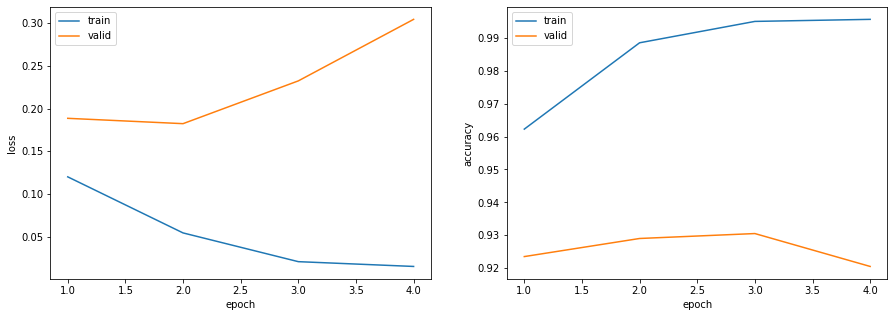

In [23]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [24]:
# 正解率の算出
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

print(
    f'正解率（学習データ）：{calculate_loss_and_accuracy(model, dataloader_train, device)[1]:.3f}')
print(
    f'正解率（検証データ）：{calculate_loss_and_accuracy(model, dataloader_valid, device)[1]:.3f}')
print(
    f'正解率（評価データ）：{calculate_loss_and_accuracy(model, dataloader_test, device)[1]:.3f}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ストリーミング出力は最後の 5000 行に切り捨てられました。
          0.6601, -0.4452, -0.7939, -0.5227,  0.9518,  0.7360, -0.1815, -0.9067,
          0.6997, -0.2339,  0.8267,  0.9872,  0.9178,  0.6260, -0.4194, -0.8162,
         -0.5022,  0.4630,  0.3346, -0.4223, -0.8419,  0.7756, -0.8943, -0.4588,
         -0.5568,  0.7209, -0.6069, -0.6582, -0.7580,  0.1649, -0.8742,  0.6731,
          0.7415, -0.0455,  0.7938, -0.8556,  0.0719,  0.5259,  0.8283, -0.8884,
         -0.8383, -0.8025,  0.8598,  0.5296,  0.9191,  0.9805,  0.0922,  0.7672,
         -0.9359,  0.7821, -0.7441, -0.8887,  0.9511, -0.8851,  0.6120,  0.8810,
          0.8667, -0.2916, -0.8112, -0.9409, -0.7888, -0.9747,  0.6716, -0.5520,
          0.4519, -0.7658,  0.9931, -0.9297, -0.1561, -0.8780,  0.9091, -0.8371,
          0.5962,  0.9293, -0.7628,  0.7554,  0.9897, -0.4196,  0.0241,  0.3963,
         -0.4118,  0.9464, -0.9188, -0.8812, -0.8338, -0.8806, -0.8168,  0.8649,
         -0.5182,  0.8937, -0.8137, -0.7225,  0.5451, -0.9178,  0.8738, -0.98